In [1]:
!pip install git+https://github.com/qubvel/segmentation_models    # install segmentation model

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-7sbizllw
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-7sbizllw
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=06b6d23df1ed0f43fa799296f484b3ea10997f6766b120a23375295e4d6fbfa1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_mg4lpyy/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [2]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL   
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa
import joblib


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
GPU is available


In [3]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import gc


In [4]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [5]:
import segmentation_models as sm        # to calculate precison ,recall and F1 Score

Segmentation Models: using `tf.keras` framework.


In [6]:
!ls

sample_data


In [7]:
!pip install kaggle

Setting up kaggle and collab enviornment

In [7]:
# taken username and key from JSON file
os.environ['KAGGLE_USERNAME'] = "harshwalia"    
os.environ['KAGGLE_KEY'] = "2d72fd594b2e141d8285316efff7a1f9" 

Get kaggle dataset API

In [8]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:11<00:00, 75.6MB/s]
100% 1.03G/1.03G [00:11<00:00, 94.2MB/s]


*Unzipping* all the files

In [9]:
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [10]:
pwd

'/content'

In [11]:
os.listdir('/content')

['.config', 'covid19-ct-scans.zip', 'covid19-ct-scans', 'sample_data']

In [12]:
data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
data = data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [13]:
np.array(data['ct_scan'])

array(['/content/covid19-ct-scans/ct_scans/coronacases_org_001.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_002.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_003.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_004.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_005.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_006.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_007.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_008.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_009.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_010.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii',
       '/cont

# Exploring the Dataset

In [14]:
ct_scan_path=[]
lung_mask_path=[]
infection_mask_path=[]
both_mask_path=[]

In [15]:
ct_scan_path=np.array(data['ct_scan'])
lung_mask_path=np.array(data['lung_mask'])
infection_mask_path=np.array(data['infection_mask'])
both_mask_path=np.array(data['lung_and_infection_mask'])

In [16]:
ct_scan_path[0]

'/content/covid19-ct-scans/ct_scans/coronacases_org_001.nii'

In [17]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.grid(None) 

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.grid(None)

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')
    plt.grid(None)

    plt.show()

In [18]:
def enhanced_img(test_img,visualize):
  test_img = test_img*255
  test_img = np.uint8(test_img)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)     # parameter passed must be of dtype uint8

  if(visualize==1):
    fig = plt.figure(figsize=(12,15))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")
    plt.grid(None)
  
    plt.subplot(1,2,2)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("Enhanced CT-Scan")
    plt.grid(None)
    
  return clahe_image   

* First Tried Manually cropping the image but it doesn't work out .
* So, now cropping the image using contours.
* From Lung mask Take contour along left lung and crop the img of left lung.
* Then from the 2nd Lung, take contour along the second Lung and crop it.
* Finally combine the both Cropped images to get the final croppped img.
* Now store the contours points because to Crop the  Ctscan and mask corresponding to each Ctscan.

In [19]:
def cropped_img(test_img,visualize):
  test_img=test_img*255
  test_img=np.uint8(test_img)
  
  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  #print(len(contours)) size=2 for both lungs

  lung1_pt=[]
  lung2_pt=[]

  # left lung
  cnt1=contours[0]  
  x,y,w,z=cv2.boundingRect(cnt1)
  crp_1=test_img[y:y+z,x:x+w]
  crp_1 = cv2.resize(crp_1, dsize=(125,250), interpolation=cv2.INTER_AREA)     
  lung1_pt.append(x);lung1_pt.append(y);lung1_pt.append(w);lung1_pt.append(z);

  crp_2=crp_1
  #Right lung
  if(len(contours)==2):
    cnt2=contours[1]
    p,q,r,s=cv2.boundingRect(cnt2)
    crp_2=test_img[q:q+s,p:p+r]
    crp_2 = cv2.resize(crp_2, dsize=(125,250), interpolation=cv2.INTER_AREA)
    lung2_pt.append(p);lung2_pt.append(q);lung2_pt.append(r);lung2_pt.append(s);
  else:
    lung2_pt.append(x);lung2_pt.append(y);lung2_pt.append(w);lung2_pt.append(z);
    # before merging two image dimensions of 2 image must be same
  ROI = np.concatenate((crp_1, crp_2), axis=1)  

  if(visualize==1):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.imshow(crp_1)
    plt.grid(None)

    plt.subplot(1,3,2)
    plt.imshow(crp_2)
    plt.grid(None)

    plt.subplot(1,3,3)
    plt.imshow(ROI)
    plt.grid(None)

    plt.show()
  
  return (ROI,lung1_pt,lung2_pt)



In [20]:
points_1=[]
points_2=[]
img_size=512

In [21]:
def read_nii_demo(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]

    return array

In [22]:
def read_nii(filepath,img_arr,string):

    global points_1
    global points_2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    # get the slices b/w 25% and 75%
    array = array[:,:,round(slices*0.25):round(slices*0.75)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    if string=='lungs':
      points_1=[]
      points_2=[]

    for img_no in range(0, array.shape[0]):
      #To remove the blurry images
      if string=='lungs' and np.unique(array[img_no]).size == 1:
        continue
      img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)  #resizing all images to the same dimensions
      # Normalising the Image
      xmax, xmin = img.max(), img.min()
      img = (img - xmin)/(xmax - xmin)
      
      if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, pts1, pts2 = cropped_img(img, visualize= 0)
          points_1.append((pts1[0], pts1[1], pts1[2], pts1[3]))
          points_2.append((pts2[0], pts2[1], pts2[2], pts2[3]))
          continue 

      if string == "cts" and img_no < len(points_1):
          img = enhanced_img(img, visualize= 0)
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

      if string == "infections" and img_no < len(points_2):
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)

        
      img_arr.append(img)

In [23]:
index=1
sample_ct=read_nii_demo(ct_scan_path[index])
sample_lung=read_nii_demo(lung_mask_path[index])
sample_infe=read_nii_demo(infection_mask_path[index])
sample_all=read_nii_demo(both_mask_path[index])

Sample images of Original Image, Lung Mask ,Infection Mask and Lung and Infection Mask

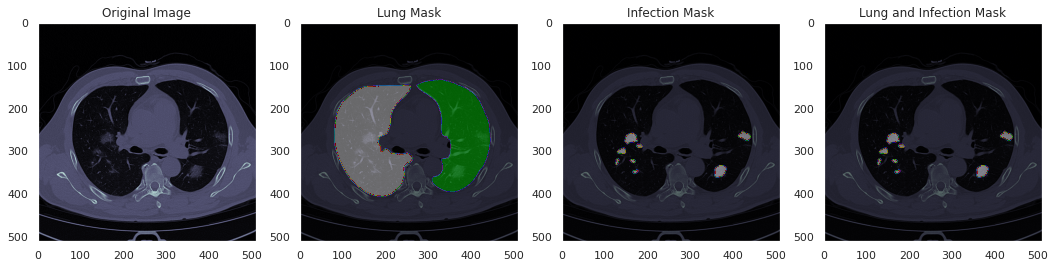

In [24]:
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

In [25]:
# normalising the sample CT_Scan and sample lung 
sample_ct=(sample_ct-sample_ct.min())/(sample_ct.max()-sample_ct.min())
sample_lung=(sample_lung-sample_lung.min())/(sample_lung.max()-sample_lung.min())


Sample Cropped Version

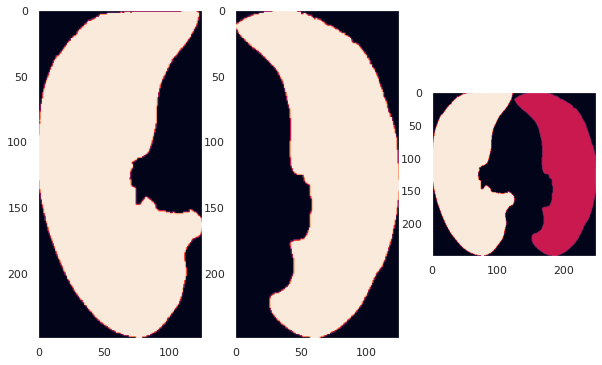

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [81, 147, 182, 261],
 [273, 135, 172, 262])

In [26]:
cropped_img(sample_lung[...,120],visualize=1)

Sample Enhanced Version

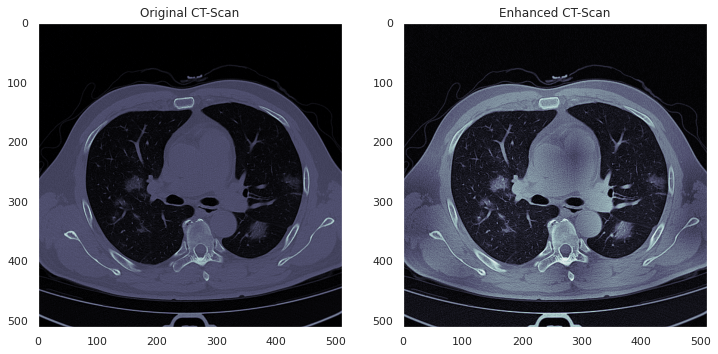

In [27]:
#sample_ct_grey=cv2.cvtColor(sample_ct[...,120],cv2.COLOR_BGR2GRAY)
img=enhanced_img(sample_ct[...,120],visualize=1)

In [28]:
cts = []
lungs = []
infections = []

In [29]:
for i in range(0, 20):
  read_nii(data.loc[i,'lung_mask'], lungs, 'lungs')
  read_nii(data.loc[i,'ct_scan'], cts, 'cts') 
  read_nii(data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


(250, 250) (250, 250)


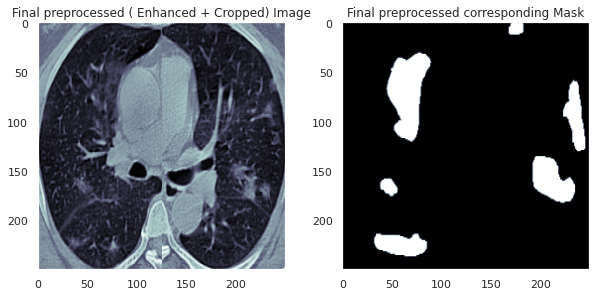

In [30]:
ind = 109
rcParams['figure.figsize'] = 10,10


plt.subplot(2, 2, 1)
plt.imshow(cts[ind], cmap='bone')
plt.title("Final preprocessed ( Enhanced + Cropped) Image")
plt.grid(None)

plt.subplot(2, 2, 2)
plt.imshow(infections[ind], cmap='bone')
plt.title("Final preprocessed corresponding Mask")
plt.grid(None)

print(cts[ind].shape, infections[ind].shape)

In [31]:
 print(len(cts))
 print(len(lungs))
 print(len(infections))

1766
0
1766


* Some of them Masks are complete Black we remove those black Masks to pass the rest of the images from segmentation Model to Segment the infection.
* In Segmentation model we have to only pass the masks which are not completely Black.

In [32]:
complete_black_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    complete_black_masks.append(i)
print("Number of complete black masks :" , len(complete_black_masks))

for index in sorted(complete_black_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 374


Left Masks

In [33]:
 print(len(cts))
 print(len(lungs))
 print(len(infections))

1392
0
1392


In [ ]:
# joblib.dump(cts, 'cts_cropped_lungs_250.pkl')

In [36]:
# files.download('cts_cropped_lungs_250.pkl')

In [139]:
joblib.dump(infections, 'infections_cropped_lungs_250.pkl')

['infections_cropped_lungs_250.pkl']

In [39]:
# files.download('infections_cropped_lungs_250.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Mounting Drive

In [43]:
drive.mount('/content/drive') 

Mounted at /content/drive


In [44]:
cts=joblib.load('/content/drive/My Drive/cts and infections/cts_cropped_lungs_250.pkl')
infections=joblib.load('/content/drive/My Drive/cts and infections/infections_cropped_lungs_250.pkl')

In [45]:
new_dim=128

In [46]:
# Resizing the images to the same dimensions
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  

In [47]:
cts = np.array(cts)
infections = np.array(infections)

In [48]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [49]:
def plot_processed_sample(array_list, color_map = 'nipy_spectral'):
   
    fig = plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')
    plt.grid(None)


    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.show()

Overlaying Infection mask Over Lungs and Plotting some Samples

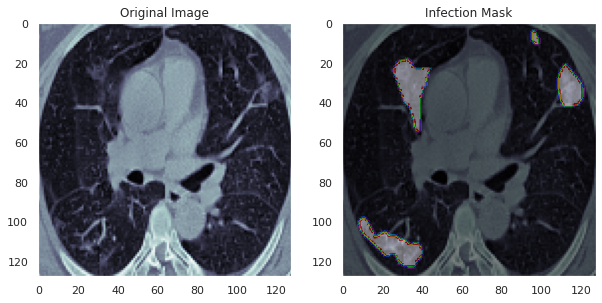

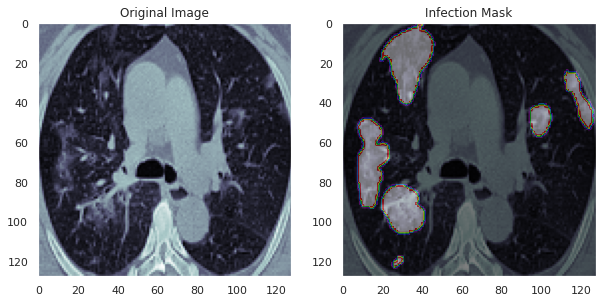

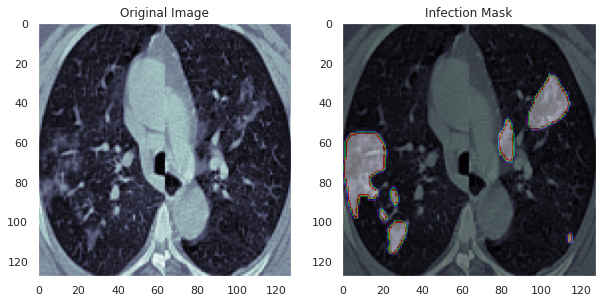

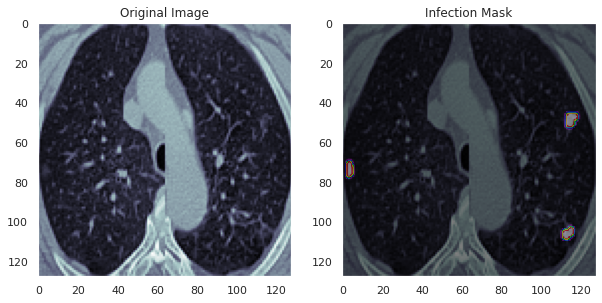

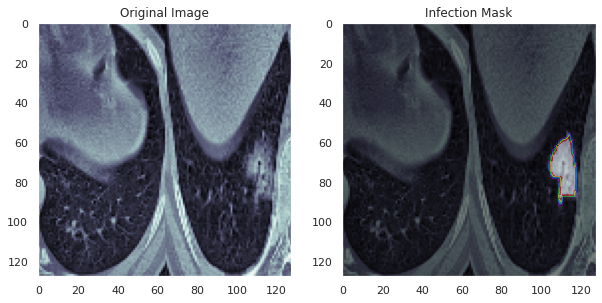

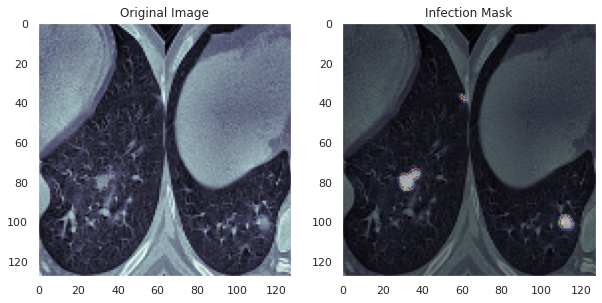

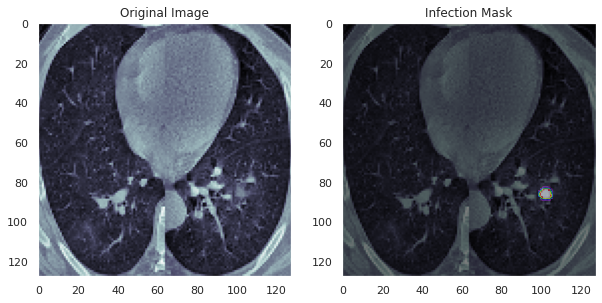

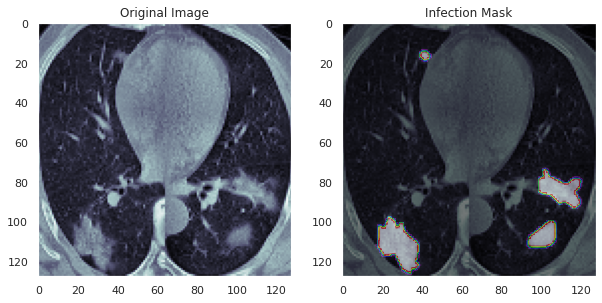

In [50]:
for index in [90,110,120,135,140,150,170,180]:
    plot_processed_sample([cts[index], infections[index]])

In [146]:
print(cts[1].min(),"min")
print(cts[1].max(),"max")
print(infections[1].min(),"min")
print(infections[1].max(),"max")

3 min
246 max
0 min
255 max


Dimensions of images

In [147]:
print(cts[1].shape)   

(128, 128)


In [148]:
len(cts)

1392

In [149]:
print(type(cts))

<class 'numpy.ndarray'>


In [150]:
print(cts[1278].shape)

(128, 128)


# Data Augmentation




In [151]:
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.80, 1.5)),
    iaa.LinearContrast((0.90, 1.5)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
        ))
], random_order=True)

In [152]:
no_of_aug_imgs = 100
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [153]:
ctsa, infa = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)

In [ ]:
# ctsa=seq(images=sample_cts)

In [ ]:
# infa=seq(images=sample_inf)

In [154]:
print(ctsa.shape, infa.shape)

(100, 128, 128) (100, 128, 128)


In [155]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=10)

print(type(rand), len(rand))

<class 'numpy.ndarray'> 10


In [156]:
rand

array([35, 22, 60, 25, 26, 61, 90, 94, 92, 30])

In [157]:
cells1 = [ctsa[i] for i in rand]
cells2 = [infa[i] for i in rand]

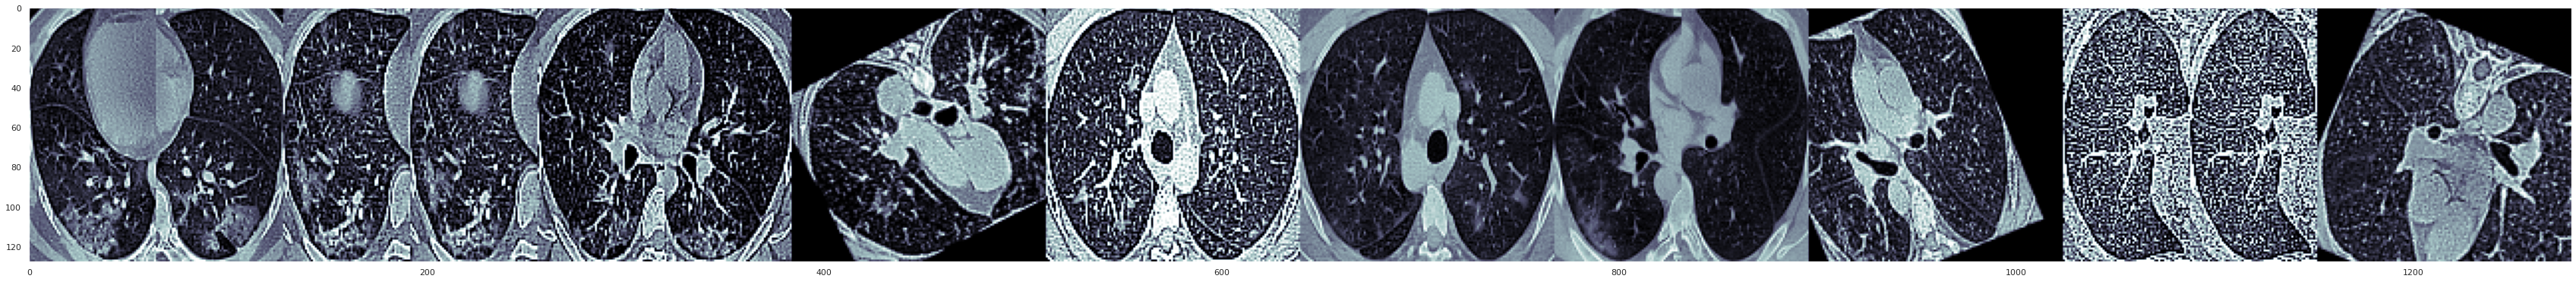

In [158]:
grid_image1 = np.hstack(cells1)
plt.grid(False)
plt.imshow(grid_image1, cmap = 'bone')

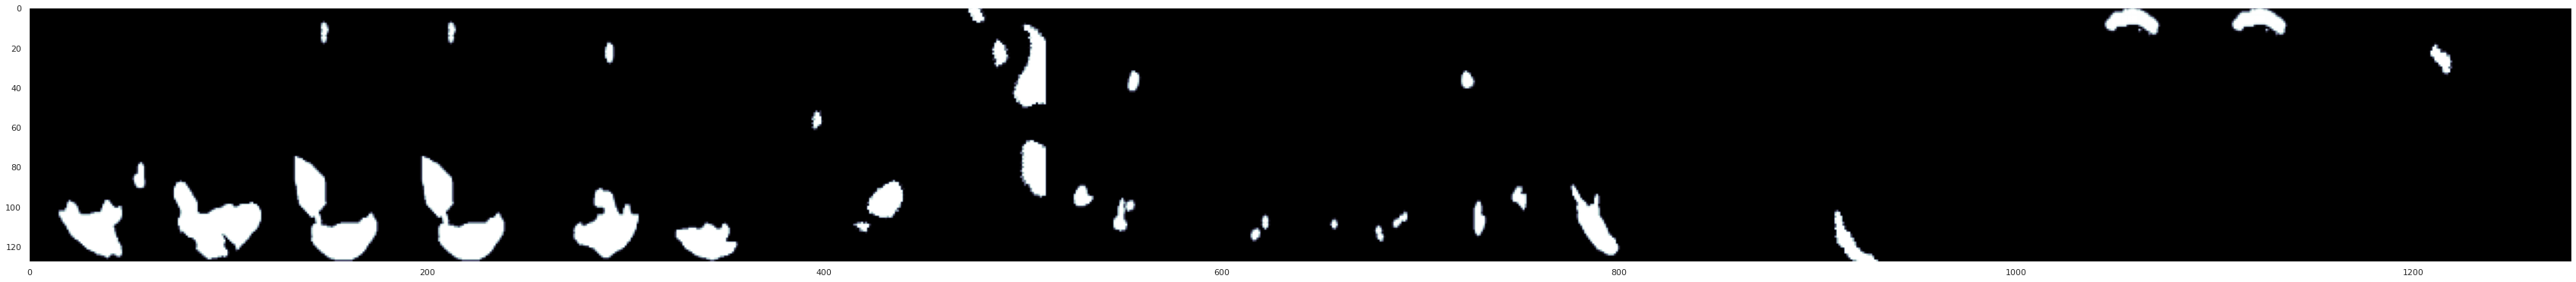

In [159]:
grid_image2 = np.hstack(cells2)
plt.grid(False)
plt.imshow(grid_image2, cmap = 'bone')

In [160]:
cts = np.concatenate((cts, ctsa), axis=0)
infections = np.concatenate((infections, infa), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
print(cts.shape, infections.shape)

(1492, 128, 128) (1492, 128, 128)


In [161]:
print(cts.min())
print(cts.max())

0
255


NORMALISING THE Images

In [162]:
cts=(cts-cts.min())/(cts.max()-cts.min())
infections=(infections-infections.min())/(infections.max()-infections.min())

In [163]:
print(cts.min())
print(cts.max())

0.0
1.0


In [164]:
print(infections.min())
print(infections.max())

0.0
1.0


In [165]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [166]:
print(len(cts), len(infections))

1492 1492


In [167]:
print(cts.shape, infections.shape)

(1492, 128, 128, 1) (1492, 128, 128, 1)


Saving the CTS and infections

In [168]:
joblib.dump(cts, 'cts_cropped_lungs_128.pkl')

['cts_cropped_lungs_128.pkl']

In [169]:
# files.download('cts_cropped_lungs_128.pkl')

In [170]:
joblib.dump(infections, 'infections_cropped_lungs_128.pkl')

['infections_cropped_lungs_128.pkl']

In [ ]:
# files.download('infections_cropped_lungs_128.pkl')

In [171]:
cts=joblib.load('/content/drive/My Drive/cts and infections/cts_cropped_lungs_128.pkl')
infections=joblib.load('/content/drive/My Drive/cts and infections/infections_cropped_lungs_128.pkl')

Dividing the Data into Train Test Split

In [172]:
x_train,x_valid,y_train,y_valid=train_test_split(cts,infections,train_size=0.7,random_state=42)

In [173]:
print(x_train.shape, x_valid.shape)

(1044, 128, 128, 1) (448, 128, 128, 1)


Loss functions and metrics

The Dice coefficient is very similar to the IoU. They are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same. Like the IoU, they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

In [174]:
# Basically we use the smooth to avoid division by 0.
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coeff(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

        

# UNET Model

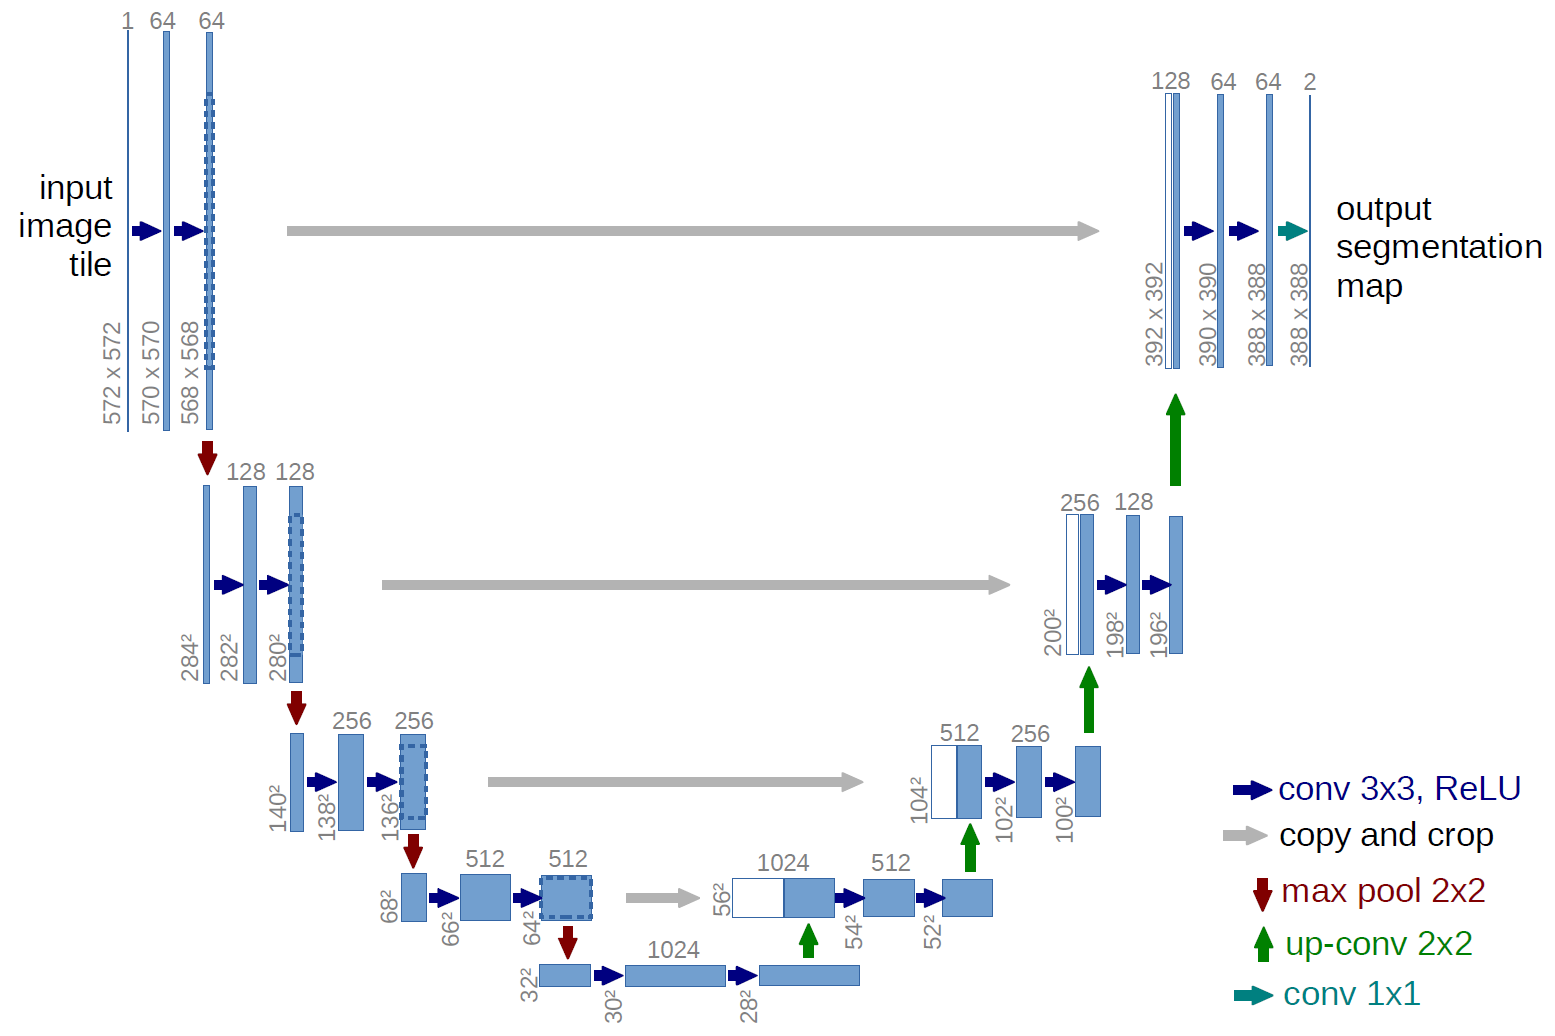


















































































































































































From the above image we construct the Unet Model.

In [175]:
inputs = Input((new_dim, new_dim, 1))

# contraction
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.4)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.4)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.4)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.4)(p4)
# ---------------------
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)
# ---------------------
# Expansion
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 128, 128, 32) 128         conv2d_20[0][0]                  
____________________________________________________________________________________________

In [176]:
batch_size = 32
epochs = 100
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Configures the model for training.

In [177]:
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

Trains the model for a fixed number of epochs (iterations on a dataset).

In [179]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/100
33/33 [==============================] - 6s 179ms/step - loss: 0.1372 - dice_coeff: 0.8068 - val_loss: 0.5144 - val_dice_coeff: 0.4556

Epoch 00001: val_dice_coeff improved from 0.40251 to 0.45564, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from 0.56270 to 0.51444, saving model to unet_covid_weights_val_loss.hdf5
Epoch 2/100
33/33 [==============================] - 6s 181ms/step - loss: 0.1275 - dice_coeff: 0.8191 - val_loss: 0.3067 - val_dice_coeff: 0.6159

Epoch 00002: val_dice_coeff improved from 0.45564 to 0.61587, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00002: val_loss improved from 0.51444 to 0.30666, saving model to unet_covid_weights_val_loss.hdf5
Epoch 3/100
33/33 [==============================] - 6s 182ms/step - loss: 0.1265 - dice_coeff: 0.8205 - val_loss: 0.2958 - val_dice_coeff: 0.6405

Epoch 00003: val_dice_coeff improved from 0.61587 to 0.64054, saving model to unet_covid_weights_dice_coeff.hdf5

Epoc

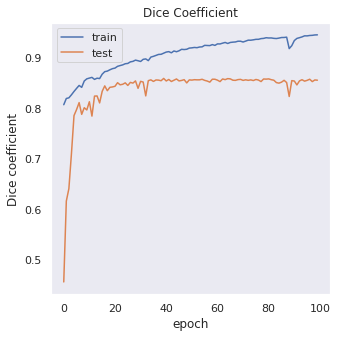

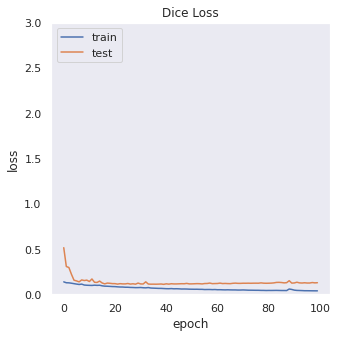

In [180]:
rcParams['figure.figsize'] = 5, 5
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 3)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [181]:
plt.rcParams["axes.grid"] = False

Generates output predictions for the input samples.

In [182]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim),cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim))
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim))
    plt.title('Predicted mask')

    plt.show()
    


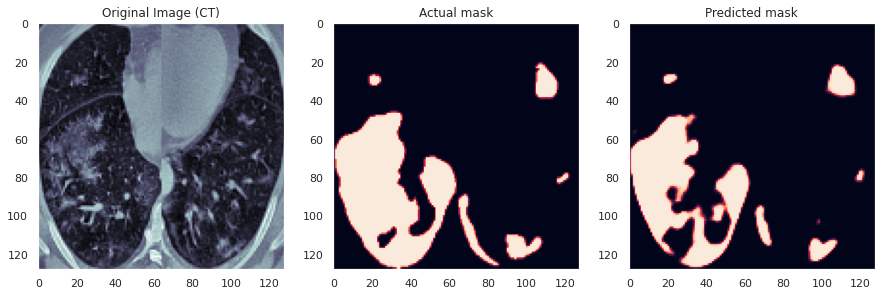

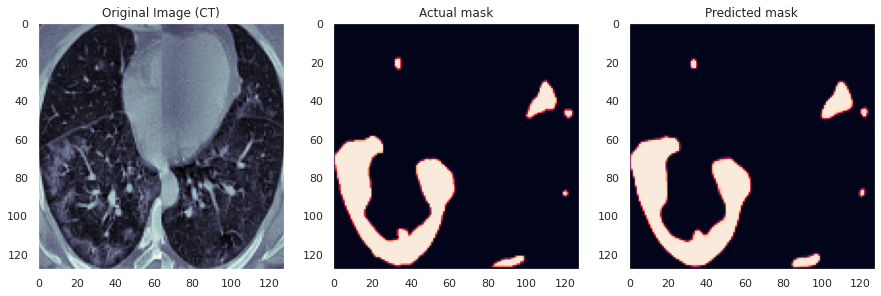

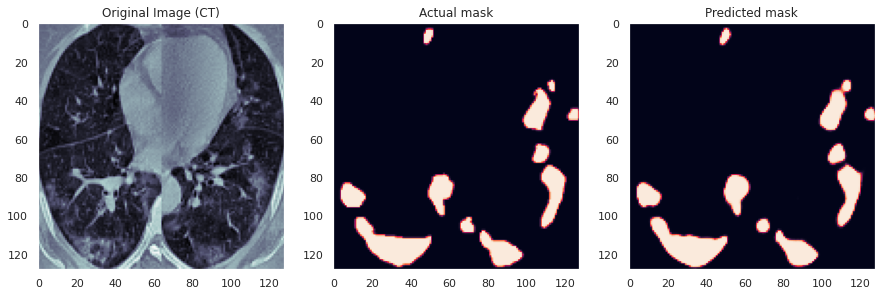

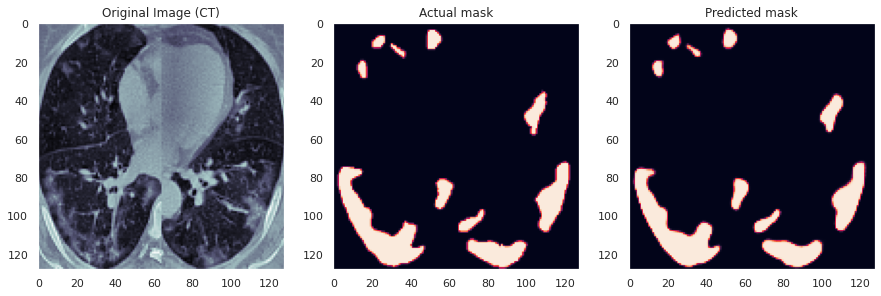

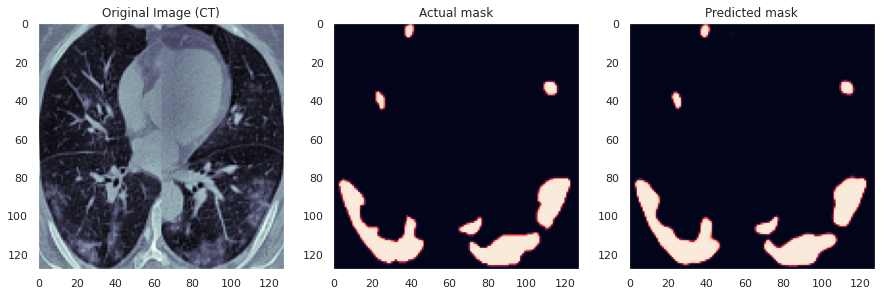

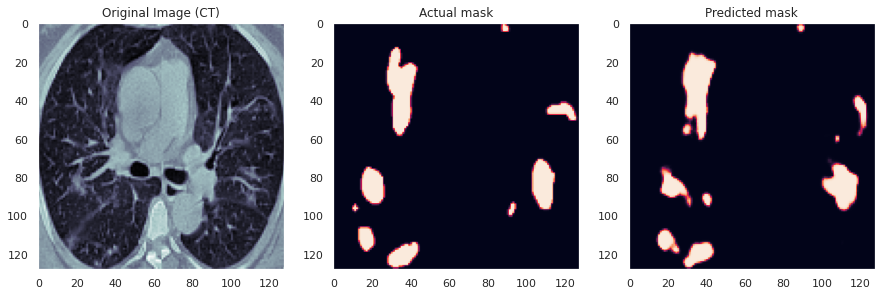

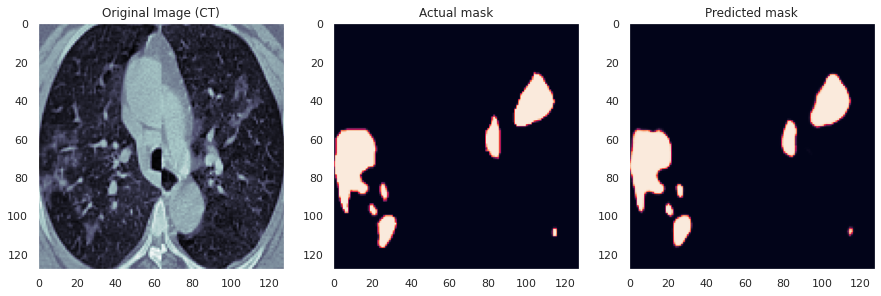

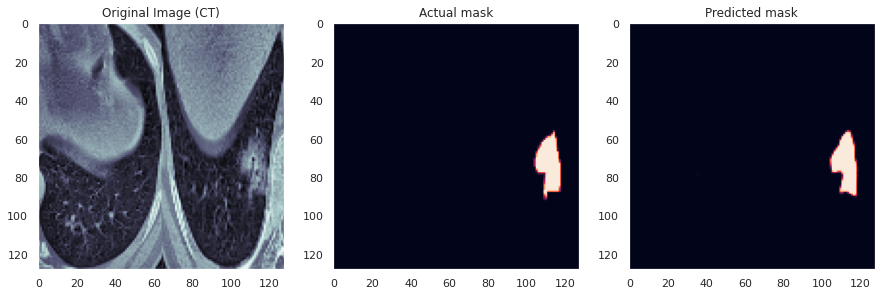

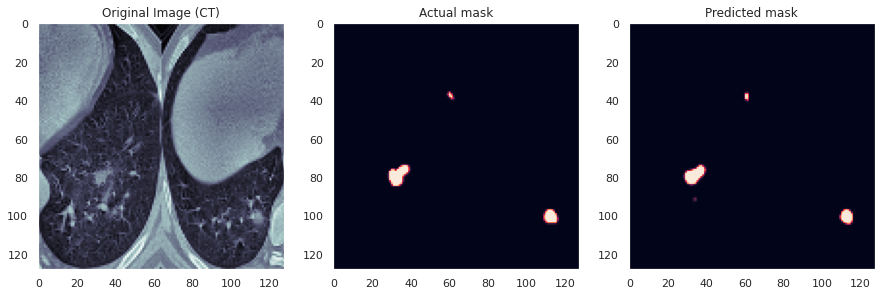

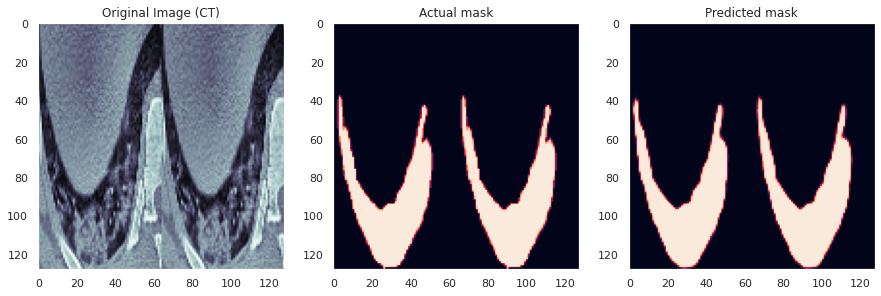

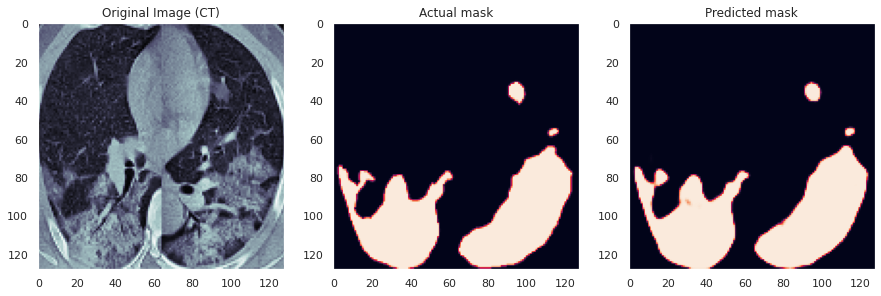

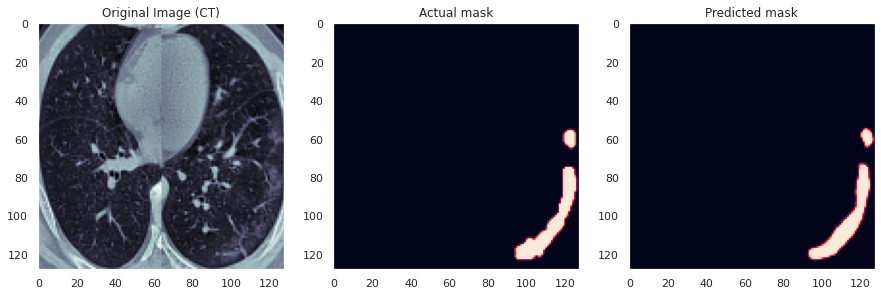

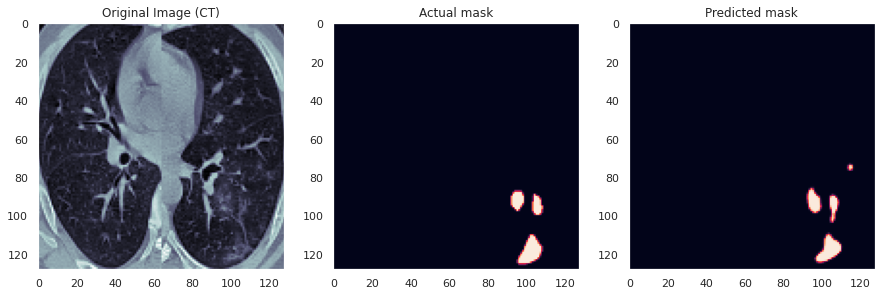

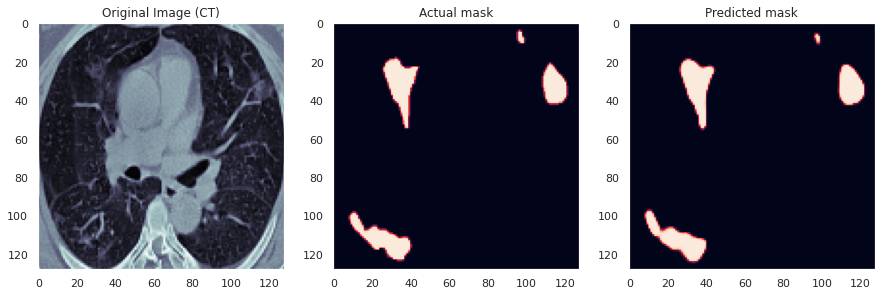

In [183]:
for i in [30,40,50,55,60,100,120,140,150,250,300,355, 380, 90]:
    compare_actual_and_predicted(i)

In [184]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

14/14 [==============================] - 1s 46ms/step - loss: 0.1278 - dice_coeff: 0.8554
test loss, test dice coefficient: [0.1277642697095871, 0.8553912043571472]


In [185]:
model.load_weights(filepath_dice_coeff)

In [186]:
model.save_weights('unet_0.85_inf_segm.h5')

In [80]:
files.download('unet_0.85_inf_segm.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [187]:
model_json = model.to_json()
with open("unet_0.85_inf_segm.json","w") as json_file:
     json_file.write(model_json)

files.download("unet_0.85_inf_segm.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [188]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

14/14 [==============================] - 1s 43ms/step - loss: 0.1099 - dice_coeff: 0.8589
test loss, test dice coefficient: [0.10992622375488281, 0.8588946461677551]


In [ ]:
# POST PROCESINGS

In [83]:
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
# model.load_weights(filepath_dice_coeff)
model.load_weights('/content/drive/My Drive/cts and infections/unet_0.85_inf_segm.h5')

In [189]:
!pip install git+https://github.com/qubvel/segmentation_models    # install segmentation model

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-pnsyp9yz
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-pnsyp9yz
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=d1580e218a5ebff72f6d396bf94c96e12f621cd6ed21c23a969678a30495ed8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-rinovmlg/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [190]:
threshold_range = np.arange(0.10,0.85, 0.05)

In [191]:
print(threshold_range)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8 ]


In [192]:
dices=[]
ious=[]
#Testing for different Threshold values
for t in threshold_range:
  iou=sm.metrics.IOUScore(threshold=t)   # Returns:	A callable iou_score instance. Can be used in model.compile(...) function.
  dice = sm.metrics.FScore(threshold=t)  # Returns: A callable f_score instance. Can be used in model.compile(...) function.
  model.compile(optimizer=Adam(lr=0.0005),loss=bce_dice_loss,metrics=[dice,iou])
  score=model.evaluate(x_valid,y_valid,batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

14/14 [==============================] - 1s 45ms/step - loss: 0.1093 - f1-score: 0.8609 - iou_score: 0.7563


In [193]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", threshold_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.860901951789856, 0.8638980984687805, 0.8655405044555664, 0.8664311766624451, 0.8670226335525513, 0.8672619462013245, 0.8672208189964294, 0.8670856356620789, 0.8667745590209961, 0.8663240075111389, 0.8656606078147888, 0.8649016618728638, 0.8638173341751099, 0.8624405264854431, 0.8603576421737671]
IOUS: [0.7560364603996277, 0.7606763243675232, 0.7632318139076233, 0.7646275758743286, 0.7655628323554993, 0.7659431099891663, 0.7658888697624207, 0.7656909227371216, 0.7652105689048767, 0.7645191550254822, 0.7634972333908081, 0.7623251676559448, 0.7606588006019592, 0.7585336565971375, 0.7553364038467407]
Best Threshold: 0.3500000000000001
Best dice score: 0.8672619462013245
Best iou score: 0.7659431099891663


Best Threshold: 0.3500000000000001


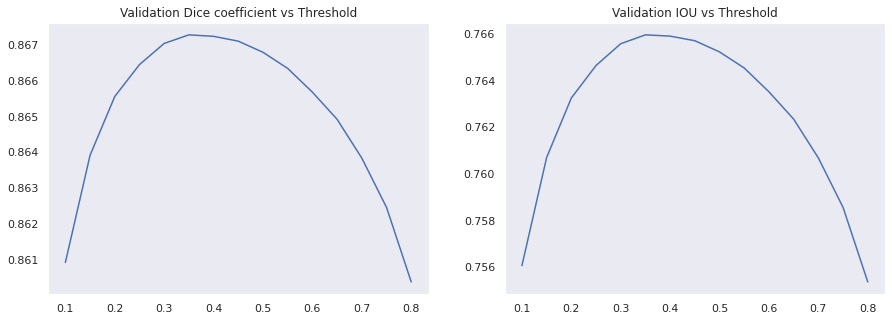

In [194]:
print("Best Threshold:", threshold_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(threshold_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(threshold_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [203]:
the_new_range = np.arange(0.33,0.38, 0.001)

In [204]:
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

14/14 [==============================] - 1s 44ms/step - loss: 0.1093 - f1-score: 0.8673 - iou_score: 0.7660


In [205]:
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

New Best Threshold: 0.35100000000000003
Best new dice score: 0.8672725558280945
Best new iou score: 0.7659593224525452


Best Threshold: 0.17900000000000005


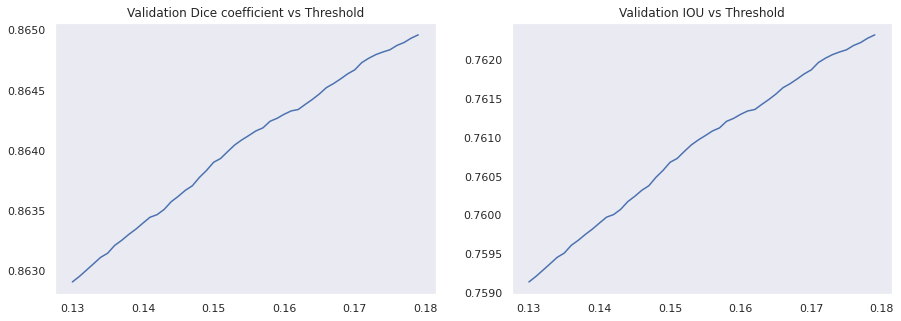

In [198]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [199]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [200]:
precisions=[]
recalls=[]
new_dices=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall,dice])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])
  new_dices.append(score[3])

14/14 [==============================] - 1s 44ms/step - loss: 0.1093 - precision: 0.9313 - recall: 0.7680 - f1-score: 0.8414


In [201]:
print("Best Threshold for dice:", the_prec_rec_range[np.argmax(new_dices)])
print("Best precision score:", precisions[np.argmax(new_dices)])
print("Best recall score:", recalls[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])

Best Threshold for dice: 0.35000000000000003
Best precision score: 0.8616018295288086
Best recall score: 0.8734021782875061
Best new dice score: 0.8672619462013245


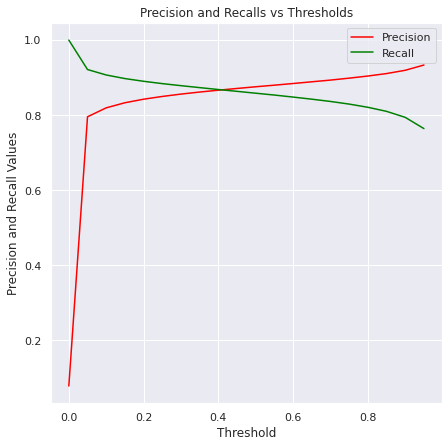

In [202]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])